# Import Data

In [1]:
import os
train_dir = os.path.join('C:/Users/User/Documents/DATASET FAHAD/train')
test_dir = os.path.join('C:/Users/User/Documents/DATASET FAHAD/test')

In [2]:
freshapples_dir = os.path.join('C:/Users/User/Documents/DATASET FAHAD/train/freshapples')
mediumfresh_dir = os.path.join('C:/Users/User/Documents/DATASET FAHAD/train/mediumfresh')
rottenapples_dir = os.path.join('C:/Users/User/Documents/DATASET FAHAD/train/rottenapples')


print('Total training fresh apples images:', len(os.listdir(freshapples_dir)))
print('\nTotal training medium fresh apple images:', len(os.listdir(mediumfresh_dir)))
print('\nTotal training rotten apples images:', len(os.listdir(rottenapples_dir)))

Total training fresh apples images: 1144

Total training medium fresh apple images: 1001

Total training rotten apples images: 1014


In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb 
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import Model


In [4]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


# Data Preprocessing

In [5]:

# this is the augmentation configuration for training

training_datagen = ImageDataGenerator(
        rescale = 1./255,                        #normalize
        rotation_range=40,                       #randomly rotated within the range of -40 degrees to 40 degrees
        width_shift_range=0.2,                   #shift image
        height_shift_range=0.2,
        shear_range=0.2,                         #shear image
        zoom_range=0.2,                          #zoom image
        horizontal_flip=True,                    #flip image horizontally
        fill_mode='nearest')                   '''specifies the strategy used to fill the newly 
                                                #created pixels after applying the data augmentation techniques.'''


# this is the augmentation configuration for testing:
# only rescaling

validation_datagen = ImageDataGenerator(rescale = 1./255) #normalize


# this is a generator that will read pictures found in subfolers of 'TRAINING_DIR', and indefinitely generate batches of augmented image data
train_generator = training_datagen.flow_from_directory(
    train_dir,                   # this is the target directory
    target_size=(224,224),          # all images will be resized to 224x224
    class_mode='categorical',       # since i use categorical_crossentropy loss, i need categorical labels
    batch_size= 100                  
)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    class_mode='categorical',
    batch_size= 50,
    shuffle=False
    
)

Found 3159 images belonging to 3 classes.
Found 1260 images belonging to 3 classes.


In [6]:
#get classes dict 
classes_dict = dict(validation_generator.class_indices)
#reverse 
classes_dict = {v: k for k,v in classes_dict.items()}

classes_dict


{0: 'freshapples', 1: 'mediumfresh', 2: 'rottenapples'}

# Build Model

In [7]:
from tensorflow.keras.applications import VGG16

     
pretrained_model=VGG16(input_shape = (224, 224, 3),   # 224x224 RGB image
                        include_top = False,          #final dense layer not included. will be created later on
                        weights ='imagenet')          #the model will be initialized with the ImageNet weights.



for layer in pretrained_model.layers:
     layer.trainable = False                  #weights of these layers will not be updated during the training process
                                              #keeping pre-trained weights fixed

In [8]:

last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output = last_layer.output


adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)


#ADD FULLY CONNECTED LAYERS ON TOP OF THE LAST LAYER OF VGG16
x = layers.Flatten()(last_output) #input layer
#Dense hidden layer
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(3, activation='softmax')(x)  #output layer         

model = Model(pretrained_model.input, x)
model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

last layer of vgg : output shape:  (None, 7, 7, 512)


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
len(model.layers)

23

In [11]:
early = tf.keras.callbacks.EarlyStopping( patience=2,
                                          monitor='loss')
# early stopping call back
# training will stop if the monitored metric ('loss') has not improved after 2 epochs.

# Train Model

In [12]:
steps_per_epoch = 3159 // 100 #training set // batch size

validation_steps = 1260 // 50 #testing set // batch size

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = 10,
            validation_steps = validation_steps,
            verbose = 1,
            callbacks=[early])

Epoch 1/10
31/31 [==============================] - 1799s 58s/step - loss: 2.9312 - accuracy: 0.5796 - val_loss: 0.5420 - val_accuracy: 0.8040
Epoch 2/10
31/31 [==============================] - 1451s 47s/step - loss: 0.4935 - accuracy: 0.8133 - val_loss: 0.2752 - val_accuracy: 0.9120
Epoch 3/10
31/31 [==============================] - 1479s 48s/step - loss: 0.3441 - accuracy: 0.8761 - val_loss: 0.2590 - val_accuracy: 0.9176
Epoch 4/10
31/31 [==============================] - 1476s 48s/step - loss: 0.3117 - accuracy: 0.8882 - val_loss: 0.2435 - val_accuracy: 0.9176
Epoch 5/10
31/31 [==============================] - 1275s 41s/step - loss: 0.2838 - accuracy: 0.8947 - val_loss: 0.2370 - val_accuracy: 0.9192
Epoch 6/10
31/31 [==============================] - 1248s 41s/step - loss: 0.2637 - accuracy: 0.9045 - val_loss: 0.1883 - val_accuracy: 0.9424
Epoch 7/10
31/31 [==============================] - 1255s 41s/step - loss: 0.2371 - accuracy: 0.9117 - val_loss: 0.1732 - val_accuracy: 0.9400

# Save Model

In [13]:
tf.keras.models.save_model(model,'VGG16_model.hdf5')

# Accuracy Graph

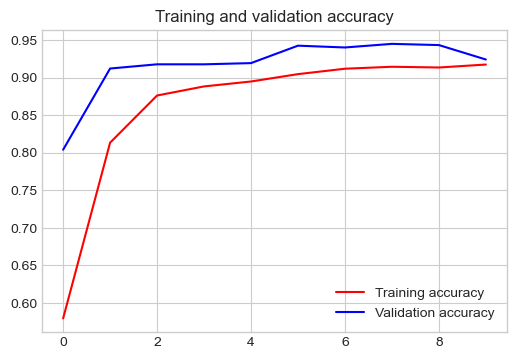

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.style.use('seaborn-whitegrid')
plt.figure(dpi = 100)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show();

# Loss Graph

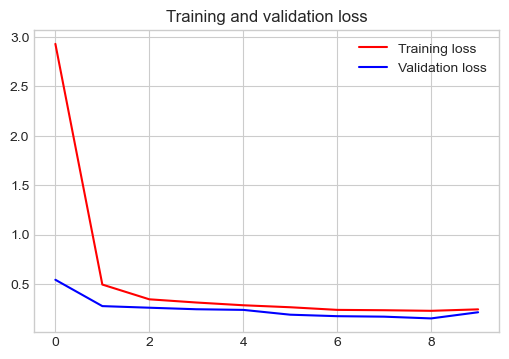

In [15]:
epochs = range(len(loss))

plt.style.use('seaborn-whitegrid')
plt.figure(dpi = 100)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show();

# Confusion Matrix

26/26 [==============================] - 376s 14s/step


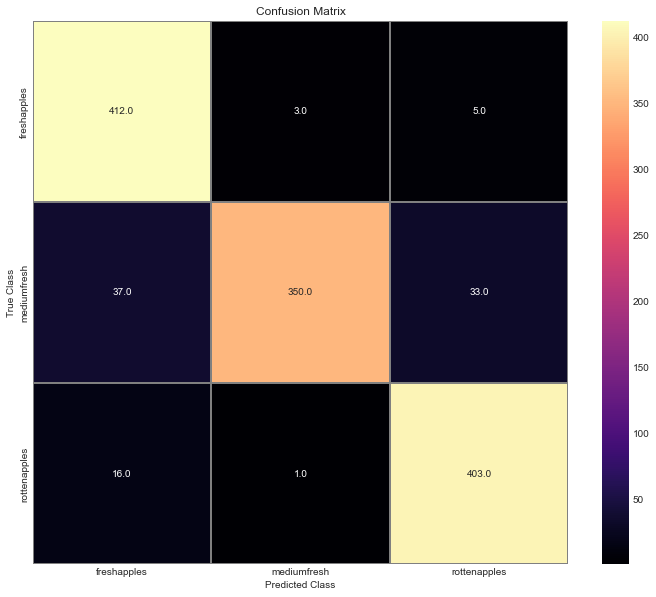

In [16]:
class_names = list(classes_dict.values())
labels = validation_generator.classes
preds =  model.predict(validation_generator)
predictions = np.argmax(preds, axis=1)
#show the confusion matrix 
conf_matrix = confusion_matrix(labels, predictions) 
# plot the confusion matrix
fig,ax = plt.subplots(figsize=(12, 10))
sb.heatmap(conf_matrix, annot=True, linewidths=0.01,cmap="magma",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
ax.set_xticklabels(labels = class_names,fontdict=None)
ax.set_yticklabels(labels = class_names,fontdict=None)
plt.show()

# Classification Report

In [17]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(validation_generator),axis=1)
print('Classification Report')
print(classification_report(labels, y_pred))

26/26 [==============================] - 410s 16s/step
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       420
           1       0.99      0.83      0.90       420
           2       0.91      0.96      0.94       420

    accuracy                           0.92      1260
   macro avg       0.93      0.92      0.92      1260
weighted avg       0.93      0.92      0.92      1260

